In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import cv2
import os
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import torchvision.models as models
import torch.optim as optim
from google.colab import files
from torch.optim.lr_scheduler import LambdaLR
import glob
import matplotlib.gridspec as gridspec

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
#Augmentations
# Scale with 0.5 - 2.0 randomly
# Random horizantal flip with prob of 0.5

In [0]:
!wget https://www.dropbox.com/s/pxcz2wdz04zxocq/CamVid.zip?dl=1 -O CamVid.zip
!unzip -qq CamVid.zip

--2019-02-24 07:57:17--  https://www.dropbox.com/s/pxcz2wdz04zxocq/CamVid.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/pxcz2wdz04zxocq/CamVid.zip [following]
--2019-02-24 07:57:17--  https://www.dropbox.com/s/dl/pxcz2wdz04zxocq/CamVid.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce2e6f9f2fc21cf5875f2f0e1b3.dl.dropboxusercontent.com/cd/0/get/Ab4qMUxWlWY-CmiZF9bh7kxuSTHbLkId_b9LrlDLg9lRDXUUOXbz8CovMBHPg5d9YnTijdy3SnYsECE7uugEkK7FH5sfOD9zwUKr59gHdW0QUg/file?dl=1# [following]
--2019-02-24 07:57:17--  https://uce2e6f9f2fc21cf5875f2f0e1b3.dl.dropboxusercontent.com/cd/0/get/Ab4qMUxWlWY-CmiZF9bh7kxuSTHbLkId_b9LrlDLg9lRDXUUOXbz8CovMBHPg5d9YnTijdy3SnYsECE7uugEkK7FH5sfOD9zwUKr59gHdW0QUg/file?dl=1
Resolving uce2e6f9

In [0]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar -O VOCtrainval.tar
!tar -xf VOCtrainval.tar

--2019-02-25 17:37:43--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval.tar’

VOCtrainval.tar     100%[===================>]   1.86G  9.28MB/s    in 3m 37s  

2019-02-25 17:41:20 (8.79 MB/s) - ‘VOCtrainval.tar’ saved [1999639040/1999639040]



In [0]:
#!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=arunava.chakraborty&password=xxxxxxx&submit=Login' https://www.cityscapes-dataset.com/login/
#!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1
#!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3
#!unzip -qq gtFine_trainvaltest.zip
#!unzip -qq leftImg8bit_trainvaltest.zip

replace README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
ckpt = torch.load('/content/gdrive/My Drive/dlabv3-83-6.77.pth')

In [0]:
def init_weights(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, .02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.constant_(0)

In [0]:
class ResNet_50 (nn.Module):
  def __init__(self, in_channels = 3, conv1_out = 64):
    super(ResNet_50,self).__init__()
    
    self.resnet_50 = models.resnet50(pretrained = True)
    
    self.relu = nn.ReLU(inplace=True)
  
  def forward(self,x):
    x = self.relu(self.resnet_50.bn1(self.resnet_50.conv1(x)))
    x = self.resnet_50.maxpool(x)
    x = self.resnet_50.layer1(x)
    x = self.resnet_50.layer2(x)
    x = self.resnet_50.layer3(x)
    
    return x

In [0]:
noise = torch.randn(1, 3, 512, 512)
m = ResNet_50()
out = m(noise)
out.shape

torch.Size([1, 1024, 32, 32])

In [0]:
class ASSP(nn.Module):
  def __init__(self,in_channels,out_channels = 256):
    super(ASSP,self).__init__()
    
    
    self.relu = nn.ReLU(inplace=True)
    
    self.conv1 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          padding = 0,
                          dilation=1,
                          bias=False)
    
    self.bn1 = nn.BatchNorm2d(out_channels)
    
    self.conv2 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          stride=1,
                          padding = 6,
                          dilation = 6,
                          bias=False)
    
    self.bn2 = nn.BatchNorm2d(out_channels)
    
    self.conv3 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          stride=1,
                          padding = 12,
                          dilation = 12,
                          bias=False)
    
    self.bn3 = nn.BatchNorm2d(out_channels)
    
    self.conv4 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          stride=1,
                          padding = 18,
                          dilation = 18,
                          bias=False)
    
    self.bn4 = nn.BatchNorm2d(out_channels)
    
    self.conv5 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          stride=1,
                          padding = 0,
                          dilation=1,
                          bias=False)
    
    self.bn5 = nn.BatchNorm2d(out_channels)
    
    self.convf = nn.Conv2d(in_channels = out_channels * 5, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          stride=1,
                          padding = 0,
                          dilation=1,
                          bias=False)
    
    self.bnf = nn.BatchNorm2d(out_channels)
    
    self.adapool = nn.AdaptiveAvgPool2d(1)  
   
  
  def forward(self,x):
    
    x1 = self.conv1(x)
    x1 = self.bn1(x1)
    x1 = self.relu(x1)
    
    x2 = self.conv2(x)
    x2 = self.bn2(x2)
    x2 = self.relu(x2)
    
    x3 = self.conv3(x)
    x3 = self.bn3(x3)
    x3 = self.relu(x3)
    
    x4 = self.conv4(x)
    x4 = self.bn4(x4)
    x4 = self.relu(x4)
    
    x5 = self.adapool(x)
    x5 = self.conv5(x5)
    x5 = self.bn5(x5)
    x5 = self.relu(x5)
    x5 = F.interpolate(x5, size = tuple(x4.shape[-2:]), mode='bilinear')
    
    #print (x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)
    x = torch.cat((x1,x2,x3,x4,x5), dim = 1) #channels first
    x = self.convf(x)
    x = self.bnf(x)
    x = self.relu(x)
    
    return x

In [0]:
noise = torch.randn(2, 3, 32, 32, device='cpu')
m = ASSP(3).to('cpu')
out = m(noise)
out.shape

In [0]:
class DeepLabv3(nn.Module):
  
  def __init__(self, nc):
    
    super(DeepLabv3, self).__init__()
    
    self.nc = nc
    
    self.resnet = ResNet_50()
    
    self.assp = ASSP(in_channels = 1024)
    
    self.conv = nn.Conv2d(in_channels = 256, out_channels = self.nc,
                          kernel_size = 1, stride=1, padding=0)    
    
    '''
    for module in self.assp.modules():
      if isinstance(module, nn.Conv2d):
        nn.init.normal_(module.weight, mean=0.0, std=0.02)
      elif isinstance(module, nn.BatchNorm2d):
        nn.init.normal_(module.weight, mean=0.01, std=0.02)
        nn.init.constant_(module.bias, 0)
        
    nn.init.normal_(self.conv.weight, mean=0.0, std=0.02)
    '''
        
  def forward(self,x):
    _, _, h, w = x.shape
    x = self.resnet(x)
    x = self.assp(x)
    x = self.conv(x)
    x = F.interpolate(x, size=(h, w), mode='bilinear') #scale_factor = 16, mode='bilinear')
    return x

In [0]:
noise = torch.randn(2, 3, 360, 360, device='cpu')
m = DeepLabv3(12).to('cpu')
out = m(noise)
out.shape

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([2, 12, 360, 360])

In [0]:
def loader(input_path, segmented_path, batch_size, h=1024, w=2048):
    
    filenames = os.listdir(segmented_path)
    total_files = len(filenames)
    
    inp_files = list(map(lambda x : x.split('.')[0] + '.jpg', filenames))
    
    if str(batch_size).lower() == 'all':
        batch_size = total_files
    
    idx = 0
    while(1):
      # Choosing random indexes of images and labels
        batch_idxs = np.random.randint(0, total_files, batch_size)
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
            # Reading normalized photo
            img = np.array(Image.open(input_path + inp_files[jj]))
            # Resizing using nearest neighbor method
            img = cv2.resize(img, (w, h), cv2.INTER_NEAREST)
            inputs.append(img)
          
            # Reading semantic image
            img = Image.open(segmented_path + filenames[jj])
            img = np.array(img)
            idx255 = img == np.ones_like(img) * 255
            img[idx255] = 0
            # Resizing using nearest neighbor method
            img = cv2.resize(img, (w, h), cv2.INTER_NEAREST)
            labels.append(img)
         
        inputs = np.stack(inputs, axis=2)
        # Changing image format to C x H x W
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels

In [0]:
###############################
'''
# Global Variables Section
training_path = '/content/train/'
segmented_path = '/content/trainannot/'
eval_path = '/content/test/'
segmented_eval_path = '/content/testannot/'
nc = 12
H = 360
W = 480
batch_size = 16
'''

'''
training_path = '/content/leftImg8bit/train/'
segmented_path = '/content/gtFine/train/'
eval_path = '/content/leftImg8bit/val/'
segmented_eval_path = '/content/gtFine/val/'
nc = 34
H = 1024
W = 2048
batch_size = 2
train_samples = len(glob.glob(training_path + '/**/*.png', recursive=True))
eval_samples = len(glob.glob(eval_path + '/**/*.png', recursive=True))
'''

training_path = '/content/VOCdevkit/VOC2012/JPEGImages/'
segmented_path = '/content/VOCdevkit/VOC2012/SegmentationClass/'
eval_path = '/content/VOCdevkit/VOC2012/JPEGImages/'
train_samples = len(os.listdir(segmented_path))
eval_samples = len(os.listdir(segmented_path))
nc = 21
H = 360
W = 500
batch_size = 16

lr = 0.001
epochs = 10
save_every = 1
print_every = 1
eval_every = 1

In [0]:
def get_class_weights(loader, num_classes, c=1.02):
    '''
    This class return the class weights for each class
    
    Arguments:
    - loader : The generator object which return all the labels at one iteration
               Do Note: That this class expects all the labels to be returned in
               one iteration
    - num_classes : The number of classes
    Return:
    - class_weights : An array equal in length to the number of classes
                      containing the class weights for each class
    '''

    _, labels = next(loader)
    all_labels = labels.flatten()
    each_class = np.bincount(all_labels, minlength=num_classes)
    prospensity_score = each_class / len(all_labels)
    class_weights = 1 / (np.log(c + prospensity_score))
    return class_weights

In [0]:
###############################
# Create here two loaders

pipe = loader(training_path, segmented_path, batch_size, h = H, w = W)
#eval_pipe = loader(eval_path, segmented_eval_path, batch_size, h = H, w = W)

In [0]:
###############################

model = DeepLabv3(nc).to(device)
#model = DeepLabV3(nc).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 92771258.75it/s]


In [0]:
class_weights = get_class_weights(pipe, nc)
criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor(class_weights).to(device), ignore_index=255)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
#optimizer = optim.SDG(model.parameters(), lr=1e-6, weight_decay=0.0001, momentum=0.9)

In [0]:
model.load_state_dict(ckpt['model_state_dict'])
optimizer.load_state_dict(ckpt['opt_state_dict'])

NameError: ignored

In [0]:
epochs = 5

In [0]:
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True, patience=3)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: (1 - (epoch / epochs)) ** 0.9)

In [0]:
all_tests = os.listdir(segmented_path)

--------------- Epoch 1 ---------------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))




Epoch 1/50... Loss 297.660665
Model saved!


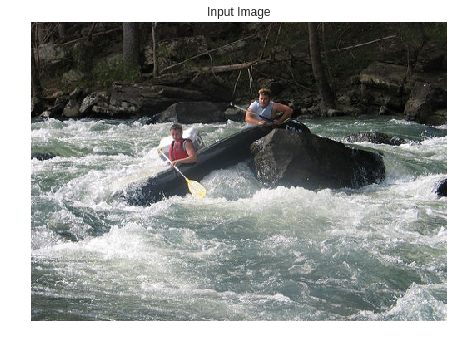

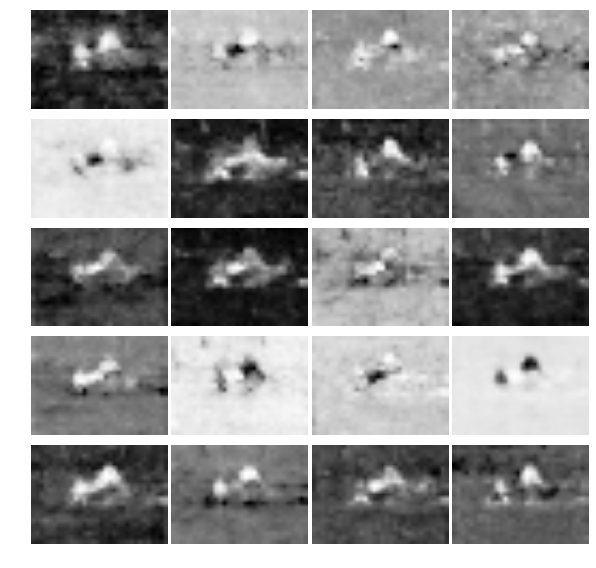

--------------- Epoch 2 ---------------


In [0]:
epochs = 50

train_losses = []
eval_losses = []

bc_train = train_samples // batch_size
bc_eval = eval_samples // batch_size

for e in range(1, epochs+1):

    train_loss = 0
    print ('-'*15,'Epoch %d' % e, '-'*15)
    
    scheduler.step()
    
    model.train()

    for _ in tqdm(range(bc_train)):
        X_batch, mask_batch = next(pipe)
        
        X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

        optimizer.zero_grad()

        out = model(X_batch.float())
        
        loss = criterion(out, mask_batch.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    print ()
    train_losses.append(train_loss)

    if (e+1) % print_every == 0:
        print ('Epoch {}/{}...'.format(e, epochs),
                'Loss {:6f}'.format(train_loss))
    '''
    if e % eval_every == 0:
        with torch.no_grad():
            model.eval()

            eval_loss = 0

            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)

                inputs, labels = inputs.to(device), labels.to(device)
                out = model(inputs.float())

                loss = criterion(out, labels.long())

                eval_loss += loss.item()

            print ()
            print ('Loss {:6f}'.format(eval_loss))

            eval_losses.append(eval_loss)
    
    scheduler.step(eval_loss)
    '''
    
    if e % save_every == 0:
        checkpoint = {
            'epochs' : e,
            'state_dict' : model.state_dict()
        }
        torch.save(checkpoint, './ckpt-enet-{}-{:2f}.pth'.format(e, train_loss))
        print ('Model saved!')
    
    
    #show(model, all_tests[np.random.randint(0, len(all_tests))])
    show_pascal(model, training_path, all_tests[np.random.randint(0, len(all_tests))])

In [0]:
fname = '0001TP_007860.png'
tmg_ = plt.imread(training_path + fname)
#tmg_ = plt.imread(eval_path + fname)
#tmg_ = a.copy()
tmg_ = cv2.resize(tmg_, (W, H), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2).to(device)
model.to(device)
model.eval()
out1 = model(tmg.float()).squeeze(0)
model.train()

In [0]:
smg_ = Image.open(segmented_path + fname)
smg_ = cv2.resize(np.array(smg_), (W, H), cv2.INTER_NEAREST)

In [0]:
out2 = out1.cpu().detach().numpy()

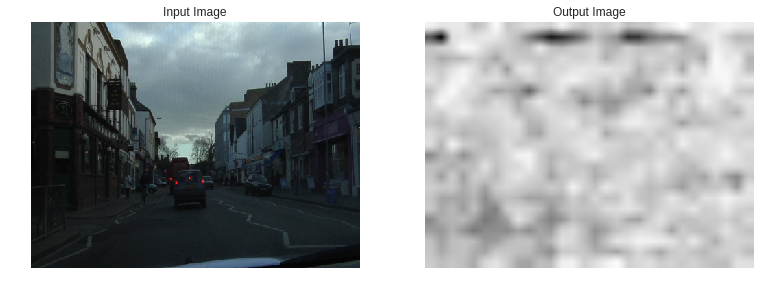

In [0]:
mno = 3 # Should be between 0 - n-1 | where n is the number of classes

figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Output Image')
plt.axis('off')
plt.imshow(out2[mno, :, :])
plt.show()

In [0]:
b_ = out1.data.max(0)[1].cpu().numpy()

In [0]:
def decode_segmap(image):
    Sky = [128, 128, 128]
    Building = [128, 0, 0]
    Pole = [192, 192, 128]
    Road_marking = [255, 69, 0]
    Road = [128, 64, 128]
    Pavement = [60, 40, 222]
    Tree = [128, 128, 0]
    SignSymbol = [192, 128, 128]
    Fence = [64, 64, 128]
    Car = [64, 0, 128]
    Pedestrian = [64, 64, 0]
    Bicyclist = [0, 128, 192]

    label_colours = np.array([Sky, Building, Pole, Road_marking, Road, 
                              Pavement, Tree, SignSymbol, Fence, Car, 
                              Pedestrian, Bicyclist]).astype(np.uint8)
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, 12):
        r[image == l] = label_colours[l, 0]
        g[image == l] = label_colours[l, 1]
        b[image == l] = label_colours[l, 2]

    rgb = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
    rgb[:, :, 0] = b
    rgb[:, :, 1] = g
    rgb[:, :, 2] = r
    return rgb

In [0]:
true_seg = decode_segmap(smg_)
pred_seg = decode_segmap(b_)

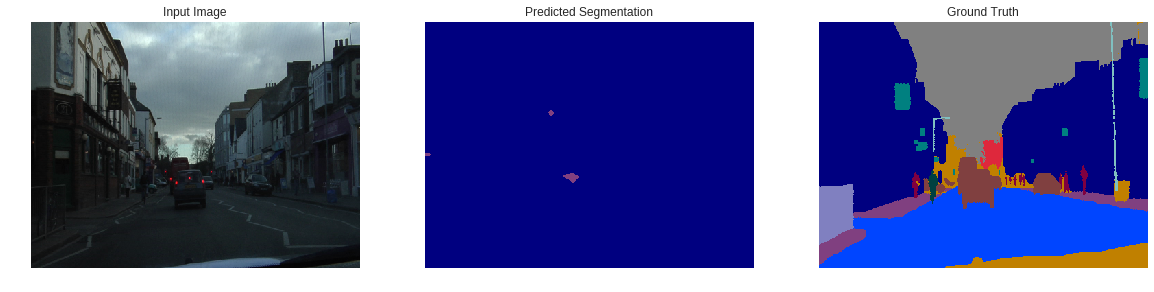

In [0]:
figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Predicted Segmentation')
plt.axis('off')
plt.imshow(pred_seg)
plt.subplot(1, 3, 3)
plt.title('Ground Truth')
plt.axis('off')
plt.imshow(true_seg)
plt.show()

In [0]:
def show(model, path, fname='0001TP_009360.png'):
  tmg_ = plt.imread(eval_path + fname)
  tmg_ = cv2.resize(tmg_, (W, H), cv2.INTER_NEAREST)
  tmg = torch.tensor(tmg_).unsqueeze(0).float()
  tmg = tmg.transpose(2, 3).transpose(1, 2).to(device)
  model.to(device)
  model.eval()
  with torch.no_grad():
      out1 = model(tmg.float()).squeeze(0)
  model.train()
  
  smg_ = Image.open(segmented_eval_path + fname)
  smg_ = cv2.resize(np.array(smg_), (W, H), cv2.INTER_NEAREST)
  
  b_ = out1.data.max(0)[1].cpu().numpy()
  
  true_seg = decode_segmap(smg_)
  pred_seg = decode_segmap(b_)
  
  figure = plt.figure(figsize=(20, 10))
  plt.subplot(1, 3, 1)
  plt.title('Input Image')
  plt.axis('off')
  plt.imshow(tmg_)
  plt.subplot(1, 3, 2)
  plt.title('Predicted Segmentation')
  plt.axis('off')
  plt.imshow(pred_seg)
  plt.subplot(1, 3, 3)
  plt.title('Ground Truth')
  plt.axis('off')
  plt.imshow(true_seg)
  plt.show()

In [0]:
def show_pascal(model, path, fname, ext='.jpg'):
  tmg_ = np.array(Image.open(path + fname.split('.')[0] + ext))
  tmg_ = cv2.resize(tmg_, (W, H), cv2.INTER_NEAREST)
  tmg = torch.tensor(tmg_).unsqueeze(0).float()
  tmg = tmg.transpose(2, 3).transpose(1, 2).to(device)
  model.eval()
  with torch.no_grad():
      out1 = model(tmg.float()).squeeze(0)
  model.train()
  
  #smg_ = Image.open(segmented_path + fname)
  
  b_ = out1.data.max(0)[1].cpu().numpy()
  
  out2 = out1.cpu().detach().numpy()
  
  '''
  true_seg = decode_segmap(smg_)
  pred_seg = decode_segmap(b_)
  
  figure = plt.figure(figsize=(20, 10))
  plt.subplot(1, 3, 1)
  plt.title('Input Image')
  plt.axis('off')
  plt.imshow(tmg_)
  plt.subplot(1, 3, 2)
  plt.title('Predicted Segmentation')
  plt.axis('off')
  plt.imshow(pred_seg)
  plt.subplot(1, 3, 3)
  plt.title('Ground Truth')
  plt.axis('off')
  plt.imshow(true_seg)
  plt.show()
  '''
  
  plt.title('Input Image')
  plt.axis('off')
  plt.imshow(tmg_)
  
  plt.figure(figsize=(10, 10))
  #fig, ax = plt.subplots(nrows=5, ncols=4)
  gs = gridspec.GridSpec(5, 4)
  gs.update(wspace=0.025, hspace=0.0)
  
  label = 0
  for ii in range(20):
    plt.subplot(gs[ii])
    plt.axis('off')
    plt.imshow(out2[label, :, :])
    label += 1
  plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


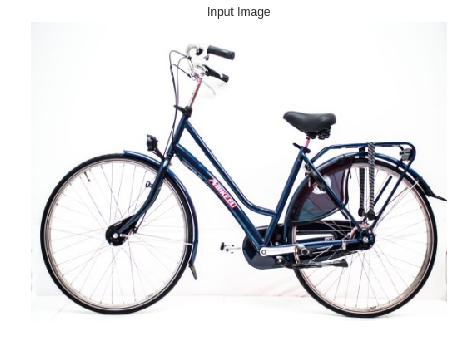

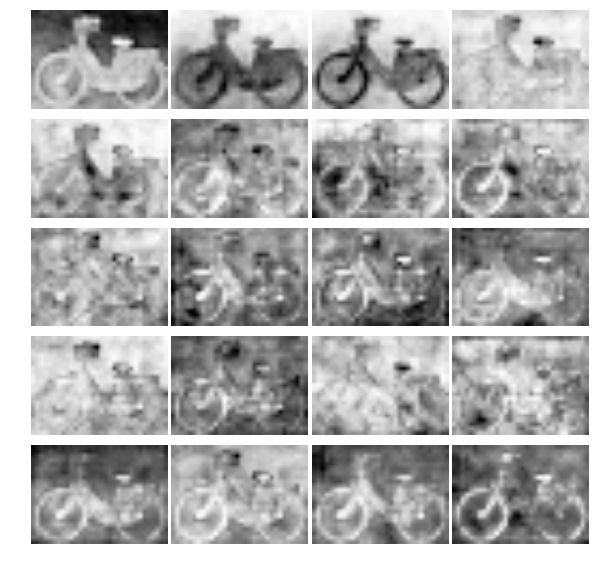

In [0]:
#show(model, training_path, all_tests[np.random.randint(0, len(all_tests))])
#show_pascal(model, training_path, all_tests[np.random.randint(0, len(all_tests))])
show_pascal(model, '/content/', 'random.png', ext='.png')

In [0]:
!wget https://a-bike.eu/wp-content/uploads/2017/04/city-bike-rental-full.jpg -O random.png

--2019-02-25 13:35:31--  https://a-bike.eu/wp-content/uploads/2017/04/city-bike-rental-full.jpg
Resolving a-bike.eu (a-bike.eu)... 149.210.196.95, 2a01:7c8:ec:0:149:210:196:95
Connecting to a-bike.eu (a-bike.eu)|149.210.196.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38290 (37K) [image/jpeg]
Saving to: ‘random.png’

random.png          100%[===================>]  37.39K  --.-KB/s    in 0.007s  

2019-02-25 13:35:31 (5.27 MB/s) - ‘random.png’ saved [38290/38290]



In [0]:
#!wget https://static1.squarespace.com/static/5ad2f82cb27e394f7bd1f1ed/t/5b86a3ccc2241bd295d94045/1535556058200/static_driving_scene_with_occlusion?format=750w -O driving.png
a = plt.imread('./driving.png')

In [0]:
a = torch.randn(2, 3, 256, 256, device=device).float()
model = DeepLabv3(12).to(device)
out = model(a)
out.shape

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([2, 12, 256, 256])

In [0]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class ConvBlock(nn.Module):
  def __init__(self,in_channels,out_channels,side_branch = True):
    super(ConvBlock,self).__init__()
    
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.side_branch = side_branch
    
    self.relu = nn.ReLU()
    
    self.sep_conv1 = SeparableConv2d(in_channels = self.in_channels,
                          out_channels = self.out_channels,
                          kernel_size = 3,
                          padding = 1)
    self.sep_conv2 = SeparableConv2d(in_channels = self.out_channels,
                          out_channels = self.out_channels,
                          kernel_size = 3,
                          padding = 1)
    self.sep_conv3 = SeparableConv2d(in_channels = self.in_channels,
                          out_channels = self.out_channels,
                          kernel_size = 3,
                          padding = 1,
                          stride = 2)
    self.conv4 = nn.Conv2d(in_channels = self.in_channels,
                          out_channels = self.out_channels,
                          kernel_size = 1,
                          padding = 1,
                          stride = 2)
    self.batchnorm = nn.BatchNorm2d()
      
        
  def forward(self,x):
    main = self.sep_conv1(x)    
    main = self.batchnorm(main)
    main = self.relu(main)
    main = self.sep_conv2(x)    
    main = self.batchnorm(main)
    main = self.relu(main)
    main = self.sep_conv3(x)    
    main = self.batchnorm(main)
    main = self.relu(main)
    
    if side_branch:
      side = F.relu(self.conv4(x))
      
    try:
      return side + main
    
    except:
      return x + main

In [0]:
import torchvision.models as models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mm = resnet_model.layer1.to(device)

with torch.no_grad():
  out = mm(a)

In [0]:
a = torch.rand(2,3,256,256).to(device)  
mmm = Res_50().to(device)
with torch.no_grad():
  out = mmm(a)
out.shape

torch.Size([2, 1024, 16, 16])

In [0]:
class DLab_lr_scheduler(_LR)

In [0]:
a = plt.imread('./train/0001TP_007470.png')
a.shape

(360, 480, 3)

In [0]:
!rm *.pth
!rm *.zip
!rm -rf test/ testannot/ train/ trainannot/ val/ valannot/

In [0]:
!git clone https://github.com/chenxi116/DeepLabv3.pytorch.git

In [0]:
!python DeepLabv3.pytorch/main.py --train --exp lr7e-3 --epochs 50 --base_lr 0.007

In [0]:
def go_test(lr):
  
  print ('Testing with Learing rate: {}'.format(lr))
  
  model = DeepLabv3(nc).to(device)
  
  class_weights = get_class_weights(pipe, nc)
  criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor(class_weights).to(device))
  
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)

  bc_train = train_samples // batch_size
  bc_eval = eval_samples // batch_size
  
  model.train()
  
  train_loss = 0
  
  for _ in tqdm(range(bc_train)):
      X_batch, mask_batch = next(pipe)

      X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

      optimizer.zero_grad()

      out = model(X_batch.float())

      loss = criterion(out, mask_batch.long())
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_loss /= bc_train
      
  with torch.no_grad():
      model.eval()
      
      eval_loss = 0
      
      for _ in tqdm(range(bc_eval)):
          inputs, labels = next(eval_pipe)

          inputs, labels = inputs.to(device), labels.to(device)
          out = model(inputs)

          loss = criterion(out, labels.long())

          eval_loss += loss.item()
          eval_loss /= bc_eval

      print ('Train Loss {:6f} | Eval Loss {:6f}'.format(train_loss, eval_loss))
  
  del model, optimizer
  
  return train_loss, eval_loss

In [0]:
info = []
fopen = open('./research.txt', 'w')

lr_range = list(np.arange(0.000001, 0.1, step=0.0001))
for ii in lr_range:
  train_loss, eval_loss = go_test(ii)
  info.append((ii, train_loss, eval_loss))
  fopen.writelines(str(ii) + ' | ' str(train_loss) + ' | ' + str(eval_loss) + '\n')
  
fopen.close()

plt.plot(list(map(info, lambda x : x[0])))
plt.plot(list(map(info, lambda x : x[1])))
plt.plot(list(map(info, lambda x : x[2])))
plt.show()

Testing with Learing rate: 1e-06


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



Exception ignored in: <bound method tqdm.__del__ of   9%|▉         | 2/22 [03:07<01:15,  3.76s/it]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread



Train Loss 54.765413 | Eval Loss 34.654435
Testing with Learing rate: 0.000101



Train Loss 37.177953 | Eval Loss 31.534314
Testing with Learing rate: 0.000201



Train Loss 33.374620 | Eval Loss 29.173665
Testing with Learing rate: 0.00030100000000000005



Train Loss 31.378158 | Eval Loss 27.794341
Testing with Learing rate: 0.00040100000000000004



Train Loss 29.243814 | Eval Loss 24.483129
Testing with Learing rate: 0.000501



Train Loss 29.516116 | Eval Loss 24.658529
Testing with Learing rate: 0.0006010000000000001



Train Loss 27.555981 | Eval Loss 23.890140
Testing with Learing rate: 0.000701



Train Loss 27.858202 | Eval Loss 22.777211
Testing with Learing rate: 0.0008010000000000001



Train Loss 27.083146 | Eval Loss 21.674177
Testing with Learing rate: 0.0009010000000000001



Train Loss 26.739354 | Eval Loss 20.282605
Testing with Learing rate: 0.001001



Train Loss 27.338028 | Eval Loss 18.204996
Testing with Learing rate: 0.001101



Train Loss 26.439085 | Eval Loss 20.954638
Testing with Learing rate: 0.001201



Train Loss 26.205469 | Eval Loss 18.703499
Testing with Learing rate: 0.001301



Train Loss 27.613895 | Eval Loss 20.568337
Testing with Learing rate: 0.001401



Train Loss 26.533725 | Eval Loss 20.084063
Testing with Learing rate: 0.001501



Train Loss 27.983816 | Eval Loss 18.303430
Testing with Learing rate: 0.001601



Train Loss 27.563341 | Eval Loss 28.314261
Testing with Learing rate: 0.001701



Train Loss 26.102756 | Eval Loss 18.245069
Testing with Learing rate: 0.001801



Train Loss 26.648579 | Eval Loss 16.941358
Testing with Learing rate: 0.001901



Train Loss 28.029876 | Eval Loss 21.559919
Testing with Learing rate: 0.002001



Train Loss 27.273367 | Eval Loss 31.126547
Testing with Learing rate: 0.0021010000000000004



Train Loss 26.852248 | Eval Loss 23.751939
Testing with Learing rate: 0.0022010000000000003



Train Loss 27.657135 | Eval Loss 31.535144
Testing with Learing rate: 0.002301



Train Loss 27.488360 | Eval Loss 20.803238
Testing with Learing rate: 0.0024010000000000004



Train Loss 27.700954 | Eval Loss 24.423808
Testing with Learing rate: 0.002501



Train Loss 28.422569 | Eval Loss 24.672195
Testing with Learing rate: 0.0026010000000000004



Train Loss 28.619485 | Eval Loss 23.162154
Testing with Learing rate: 0.0027010000000000003



Train Loss 29.149393 | Eval Loss 27.167461
Testing with Learing rate: 0.002801



Train Loss 29.053394 | Eval Loss 23.621543
Testing with Learing rate: 0.0029010000000000004



Train Loss 30.726516 | Eval Loss 26.676796
Testing with Learing rate: 0.003001



Train Loss 27.661510 | Eval Loss 28.064210
Testing with Learing rate: 0.0031010000000000005



Train Loss 29.090334 | Eval Loss 33.671609
Testing with Learing rate: 0.0032010000000000003



Train Loss 29.260848 | Eval Loss 37.240886
Testing with Learing rate: 0.003301



Train Loss 29.573950 | Eval Loss 34.712924
Testing with Learing rate: 0.0034010000000000004



Train Loss 29.797437 | Eval Loss 36.064853
Testing with Learing rate: 0.003501



Train Loss 29.137862 | Eval Loss 31.235312
Testing with Learing rate: 0.0036010000000000005


KeyboardInterrupt: ignored

In [0]:
for ii in tqdm(range(10)):
  sleep(1)

In [0]:
from time import sleep

In [0]:
class ASPP(nn.Module):
    def __init__(self, num_classes):
        super(ASPP, self).__init__()
        
        ic_conv = 1024
        self.conv_1x1_1 = nn.Conv2d(ic_conv, 256, kernel_size=1)
        self.bn_conv_1x1_1 = nn.BatchNorm2d(256)

        self.conv_3x3_1 = nn.Conv2d(ic_conv, 256, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn_conv_3x3_1 = nn.BatchNorm2d(256)

        self.conv_3x3_2 = nn.Conv2d(ic_conv, 256, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn_conv_3x3_2 = nn.BatchNorm2d(256)

        self.conv_3x3_3 = nn.Conv2d(ic_conv, 256, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn_conv_3x3_3 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_1x1_2 = nn.Conv2d(ic_conv, 256, kernel_size=1)
        self.bn_conv_1x1_2 = nn.BatchNorm2d(256)

        self.conv_1x1_3 = nn.Conv2d(1280, 256, kernel_size=1) # (1280 = 5*256)
        self.bn_conv_1x1_3 = nn.BatchNorm2d(256)

        self.conv_1x1_4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, feature_map):
        # (feature_map has shape (batch_size, 512, h/16, w/16)) (assuming self.resnet is ResNet18_OS16 or ResNet34_OS16. If self.resnet instead is ResNet18_OS8 or ResNet34_OS8, it will be (batch_size, 512, h/8, w/8))

        feature_map_h = feature_map.size()[2] # (== h/16)
        feature_map_w = feature_map.size()[3] # (== w/16)

        out_1x1 = F.relu(self.bn_conv_1x1_1(self.conv_1x1_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_1 = F.relu(self.bn_conv_3x3_1(self.conv_3x3_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_2 = F.relu(self.bn_conv_3x3_2(self.conv_3x3_2(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_3 = F.relu(self.bn_conv_3x3_3(self.conv_3x3_3(feature_map))) # (shape: (batch_size, 256, h/16, w/16))

        out_img = self.avg_pool(feature_map) # (shape: (batch_size, 512, 1, 1))
        out_img = F.relu(self.bn_conv_1x1_2(self.conv_1x1_2(out_img))) # (shape: (batch_size, 256, 1, 1))
        out_img = F.upsample(out_img, size=(feature_map_h, feature_map_w), mode="bilinear") # (shape: (batch_size, 256, h/16, w/16))

        out = torch.cat([out_1x1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1) # (shape: (batch_size, 1280, h/16, w/16))
        out = F.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out))) # (shape: (batch_size, 256, h/16, w/16))
        out = self.conv_1x1_4(out) # (shape: (batch_size, num_classes, h/16, w/16))

        return out

class ASPP_Bottleneck(nn.Module):
    def __init__(self, num_classes):
        super(ASPP_Bottleneck, self).__init__()

        self.conv_1x1_1 = nn.Conv2d(4*512, 256, kernel_size=1)
        self.bn_conv_1x1_1 = nn.BatchNorm2d(256)

        self.conv_3x3_1 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=6, dilation=6)
        self.bn_conv_3x3_1 = nn.BatchNorm2d(256)

        self.conv_3x3_2 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=12, dilation=12)
        self.bn_conv_3x3_2 = nn.BatchNorm2d(256)

        self.conv_3x3_3 = nn.Conv2d(4*512, 256, kernel_size=3, stride=1, padding=18, dilation=18)
        self.bn_conv_3x3_3 = nn.BatchNorm2d(256)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.conv_1x1_2 = nn.Conv2d(4*512, 256, kernel_size=1)
        self.bn_conv_1x1_2 = nn.BatchNorm2d(256)

        self.conv_1x1_3 = nn.Conv2d(1280, 256, kernel_size=1) # (1280 = 5*256)
        self.bn_conv_1x1_3 = nn.BatchNorm2d(256)

        self.conv_1x1_4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, feature_map):
        # (feature_map has shape (batch_size, 4*512, h/16, w/16))

        feature_map_h = feature_map.size()[2] # (== h/16)
        feature_map_w = feature_map.size()[3] # (== w/16)

        out_1x1 = F.relu(self.bn_conv_1x1_1(self.conv_1x1_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_1 = F.relu(self.bn_conv_3x3_1(self.conv_3x3_1(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_2 = F.relu(self.bn_conv_3x3_2(self.conv_3x3_2(feature_map))) # (shape: (batch_size, 256, h/16, w/16))
        out_3x3_3 = F.relu(self.bn_conv_3x3_3(self.conv_3x3_3(feature_map))) # (shape: (batch_size, 256, h/16, w/16))

        out_img = self.avg_pool(feature_map) # (shape: (batch_size, 512, 1, 1))
        out_img = F.relu(self.bn_conv_1x1_2(self.conv_1x1_2(out_img))) # (shape: (batch_size, 256, 1, 1))
        out_img = F.upsample(out_img, size=(feature_map_h, feature_map_w), mode="bilinear") # (shape: (batch_size, 256, h/16, w/16))

        out = torch.cat([out_1x1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1) # (shape: (batch_size, 1280, h/16, w/16))
        out = F.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out))) # (shape: (batch_size, 256, h/16, w/16))
        out = self.conv_1x1_4(out) # (shape: (batch_size, num_classes, h/16, w/16))

        return out

In [0]:
class DeepLabV3(nn.Module):
    def __init__(self, nc=12):
        super(DeepLabV3, self).__init__()

        self.num_classes = nc

        #self.model_id = model_id
        #self.project_dir = project_dir
        #self.create_model_dirs()

        self.resnet = ResNet_50() # NOTE! specify the type of ResNet here
        self.aspp = ASPP(num_classes=self.num_classes) # NOTE! if you use ResNet50-152, set self.aspp = ASPP_Bottleneck(num_classes=self.num_classes) instead

    def forward(self, x):
        # (x has shape (batch_size, 3, h, w))

        h = x.size()[2]
        w = x.size()[3]

        feature_map = self.resnet(x) # (shape: (batch_size, 512, h/16, w/16)) (assuming self.resnet is ResNet18_OS16 or ResNet34_OS16. If self.resnet is ResNet18_OS8 or ResNet34_OS8, it will be (batch_size, 512, h/8, w/8). If self.resnet is ResNet50-152, it will be (batch_size, 4*512, h/16, w/16))
        #print (feature_map.shape)
        output = self.aspp(feature_map) # (shape: (batch_size, num_classes, h/16, w/16))

        output = F.upsample(output, size=(h, w), mode="bilinear") # (shape: (batch_size, num_classes, h, w))

        return output

In [0]:
noise = torch.randn(2, 3, 360, 360, device='cpu')
m = DeepLabV3(12).to('cpu')
out = m(noise)
out.shape

torch.Size([2, 1024, 23, 23])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([2, 12, 360, 360])

In [0]:
loss_fn = criterion
num_epochs = 10

epoch_losses_train = []
epoch_losses_val = []
for epoch in range(num_epochs):
    print ("###########################")
    print ("######## NEW EPOCH ########")
    print ("###########################")
    print ("epoch: %d/%d" % (epoch+1, num_epochs))

    ############################################################################
    # train:
    ############################################################################
    network.train() # (set in training mode, this affects BatchNorm and dropout)
    batch_losses = []
    for step, (imgs, label_imgs) in enumerate(train_loader):
        #current_time = time.time()

        imgs = Variable(imgs).cuda() # (shape: (batch_size, 3, img_h, img_w))
        label_imgs = Variable(label_imgs.type(torch.LongTensor)).cuda() # (shape: (batch_size, img_h, img_w))

        outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))

        # compute the loss:
        loss = loss_fn(outputs, label_imgs)
        loss_value = loss.data.cpu().numpy()
        batch_losses.append(loss_value)

        # optimization step:
        optimizer.zero_grad() # (reset gradients)
        loss.backward() # (compute gradients)
        optimizer.step() # (perform optimization step)

        #print (time.time() - current_time)

    epoch_loss = np.mean(batch_losses)
    epoch_losses_train.append(epoch_loss)
    with open("%s/epoch_losses_train.pkl" % network.model_dir, "wb") as file:
        pickle.dump(epoch_losses_train, file)
    print ("train loss: %g" % epoch_loss)
    plt.figure(1)
    plt.plot(epoch_losses_train, "k^")
    plt.plot(epoch_losses_train, "k")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("train loss per epoch")
    plt.savefig("%s/epoch_losses_train.png" % network.model_dir)
    plt.close(1)

    print ("####")

    ############################################################################
    # val:
    ############################################################################
    network.eval() # (set in evaluation mode, this affects BatchNorm and dropout)
    batch_losses = []
    for step, (imgs, label_imgs, img_ids) in enumerate(val_loader):
        with torch.no_grad(): # (corresponds to setting volatile=True in all variables, this is done during inference to reduce memory consumption)
            imgs = Variable(imgs).cuda() # (shape: (batch_size, 3, img_h, img_w))
            label_imgs = Variable(label_imgs.type(torch.LongTensor)).cuda() # (shape: (batch_size, img_h, img_w))

            outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))

            # compute the loss:
            loss = loss_fn(outputs, label_imgs)
            loss_value = loss.data.cpu().numpy()
            batch_losses.append(loss_value)

    epoch_loss = np.mean(batch_losses)
    epoch_losses_val.append(epoch_loss)
    with open("%s/epoch_losses_val.pkl" % network.model_dir, "wb") as file:
        pickle.dump(epoch_losses_val, file)
    print ("val loss: %g" % epoch_loss)
    plt.figure(1)
    plt.plot(epoch_losses_val, "k^")
    plt.plot(epoch_losses_val, "k")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("val loss per epoch")
    plt.savefig("%s/epoch_losses_val.png" % network.model_dir)
    plt.close(1)

    # save the model weights to disk:
    checkpoint_path = network.checkpoints_dir + "/model_" + model_id +"_epoch_" + str(epoch+1) + ".pth"
    torch.save(network.state_dict(), checkpoint_path)

In [0]:
def loader(training_path, segmented_path, batch_size, h=512, w=512):
    filenames_t = os.listdir(training_path)
    total_files_t = len(filenames_t)
    
    filenames_s = os.listdir(segmented_path)
    total_files_s = len(filenames_s)
    
    assert(total_files_t == total_files_s)
    
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
    
    idx = 0
    while(1):
        # Choosing random indexes of images and labels
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
            # Reading normalized photo
            img = np.array(Image.open(training_path + filenames_t[jj]))
            # Resizing using nearest neighbor method
            img = cv2.resize(img, (w, h), cv2.INTER_NEAREST)
            inputs.append(img)
          
            # Reading semantic image
            img = Image.open(segmented_path + filenames_s[jj])
            img = np.array(img)
            # Resizing using nearest neighbor method
            img = cv2.resize(img, (w, h), cv2.INTER_NEAREST)
            labels.append(img)
         
        inputs = np.stack(inputs, axis=2)
        # Changing image format to C x H x W
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels

In [0]:
def loader(input_path, segmented_path, batch_size, h=1024, w=2048):
    filenames_t = sorted(glob.glob(input_path + '/**/*.png', recursive=True), key=lambda x : int(x.split('/')[-1].split('_')[1] + x.split('/')[-1].split('_')[2]))
    total_files_t = len(filenames_t)
    
    filenames_s = sorted(glob.glob(segmented_path + '/**/*labelIds.png', recursive=True), key=lambda x : int(x.split('/')[-1].split('_')[1] + x.split('/')[-1].split('_')[2]))
    
    total_files_s = len(filenames_s)
    
    assert(total_files_t == total_files_s)
    
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
    
    idx = 0
    while(1):
      # Choosing random indexes of images and labels
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
            # Reading normalized photo
            img = np.array(Image.open(filenames_t[jj]))
            # Resizing using nearest neighbor method
            inputs.append(img)
          
            # Reading semantic image
            img = Image.open(filenames_s[jj])
            img = np.array(img)
            # Resizing using nearest neighbor method
            labels.append(img)
         
        inputs = np.stack(inputs, axis=2)
      # Changing image format to C x H x W
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

drive_service = build('drive', 'v3')

def save_to_drive(fcname, fname):
    file_metadata = {
        'name' : '{}.pth'.format(fname)
    }

    media = MediaFileUpload('/content/{}'.format(fcname), resumable=True)
    
    created = drive_service.files().create(body=file_metadata,
                                           media_body=media,
                                           fields='id').execute()
    
    print ('[INFO] File created with id = {}'.format(created['id']))

In [0]:
save_to_drive('ckpt-enet-48-9.758419.pth', 'ckpt-deeplabv3-pascalvoc2012-bs16-11000iter.pth')

[INFO] File created with id = 1Pv-BYJa55uW4iSnQEuUmbM0-c_gNuC9o


In [0]:
!wget https://images.spot.im/v1/production/blbaeohn5bg5yofriny7 -O random.png

--2019-02-25 13:17:28--  https://cdn.psychologytoday.com/sites/default/files/styles/image-article_inline_full/public/field_blog_entry_images/2018-02/dog_looks_at_face.jpeg?itok=VMHRLQ5F
Resolving cdn.psychologytoday.com (cdn.psychologytoday.com)... 54.230.202.184, 54.230.202.207, 54.230.202.44, ...
Connecting to cdn.psychologytoday.com (cdn.psychologytoday.com)|54.230.202.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45866 (45K) [image/jpeg]
Saving to: ‘random.png’

random.png          100%[===================>]  44.79K  --.-KB/s    in 0.007s  

2019-02-25 13:17:28 (5.96 MB/s) - ‘random.png’ saved [45866/45866]

